# alternative to 2d polynomial

want to fit surface to panstarrs residuals, and then divide image by this surface (after normalizing).  The 2d polynomial does not work for the mosaic data, so I'd like to try something else.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clipped_stats

In [3]:
os.chdir('/Users/rfinn/research/Virgo/Halpha/mosaic-images/')

## Aligning images

I already aligned the images N up, E to left using 

```
MOS_align_images.py
```

The WCS aligned images are the VF*.fits images

In [3]:
!ls

VF-217.470+3.421-MOS-20120422-NGC5846_07-Ha4.fits
VF-217.470+3.421-MOS-20120422-NGC5846_07-Ha4.weight.fits
VF-217.470+3.421-MOS-20120422-NGC5846_07-R.fits
VF-217.470+3.421-MOS-20120422-NGC5846_07-R.weight.fits
VF-222.729+2.735-MOS-20120423-NGC5846_06-Ha4.fits
VF-222.729+2.735-MOS-20120423-NGC5846_06-Ha4.weight.fits
VF-222.729+2.735-MOS-20120423-NGC5846_06-R.fits
VF-222.729+2.735-MOS-20120423-NGC5846_06-R.weight.fits
VF-223.132+3.623-MOS-20130415-NGC5846_05-Ha4.fits
VF-223.132+3.623-MOS-20130415-NGC5846_05-Ha4.weight.fits
VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits
VF-223.132+3.623-MOS-20130415-NGC5846_05-R.weight.fits
VF-225.207+1.904-MOS-20110404-NGC5846_02-Ha4.fits
VF-225.207+1.904-MOS-20110404-NGC5846_02-Ha4.weight.fits
VF-225.207+1.904-MOS-20110404-NGC5846_02-R.fits
VF-225.207+1.904-MOS-20110404-NGC5846_02-R.weight.fits
VF-225.738+0.831-MOS-20120418-NGC5846_04-Ha4.fits
VF-225.738+0.831-MOS-20120418-NGC5846_04-Ha4.weight.fits
VF-225.738+0.831-MOS-20120418-NGC5846_04-R.fits
VF-22

In [4]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits --instrument m --filter R

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


ZP = 23.634 +/- 0.001, VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits


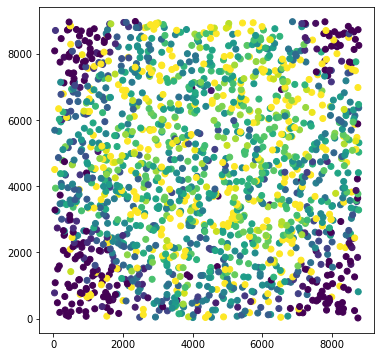

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(zp.residual_allx,zp.residual_ally,c=zp.residual_all,vmin=.96,vmax=1.04)

# Examples 

https://docs.astropy.org/en/stable/convolution/index.html

https://stackoverflow.com/questions/39727040/matplotlib-2d-plot-from-x-y-z-values

In [21]:
def fit_surface2points(x,y,z,vmin=.96,vmax=1.04):
    """would like another way to fit residuals, maybe boxcar smooth?
    polynomial sometimes introduces too much structure

    https://stackoverflow.com/questions/39727040/matplotlib-2d-plot-from-x-y-z-values
    """
    from scipy.interpolate import interp2d

    # f will be a function with two arguments (x and y coordinates),
    # but those can be array_like structures too, in which case the
    # result will be a matrix representing the values in the grid 
    # specified by those arguments
    f = interp2d(x,y,z,kind="linear")

    x_coords = np.arange(min(x),max(x)+1)
    y_coords = np.arange(min(y),max(y)+1)
    Z = f(x_coords,y_coords)

    fig = plt.imshow(Z,
           extent=[min(x),max(x),min(y),max(y)],
           origin="lower",vmin=vmin,vmax=vmax)
    plt.colorbar()
    # Show the positions of the sample points, just to have some reference
    fig.axes.set_autoscale_on(False)
    plt.scatter(x,y,400,facecolors='none',vmin=vmin,vmax=vmax)
    
    pass 

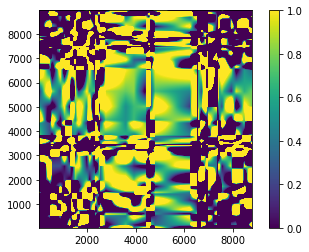

In [22]:
fit_surface2points(zp.residual_allx,zp.residual_ally,zp.residual_all)
# doesn't seem to work that well...

[Text(0, -5.0, ''),
 Text(0, 0.0, ''),
 Text(0, 5.0, ''),
 Text(0, 10.0, ''),
 Text(0, 15.0, ''),
 Text(0, 20.0, ''),
 Text(0, 25.0, ''),
 Text(0, 30.0, ''),
 Text(0, 35.0, ''),
 Text(0, 40.0, '')]

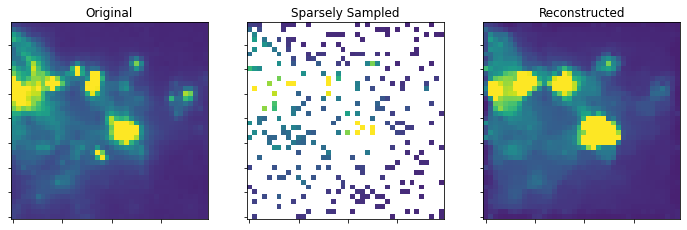

In [23]:
# from https://docs.astropy.org/en/stable/convolution/index.html
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

# Load the data from data.astropy.org
filename = get_pkg_data_filename('galactic_center/gc_msx_e.fits')

hdu = fits.open(filename)[0]
img = hdu.data[50:90, 60:100] * 1e5

rng = np.random.default_rng(1379)
indices = rng.integers(low=0, high=img.size, size=300)

sampled_data = img.flat[indices]

# Build a new, sparsely sampled version of the original image
new_img = np.tile(np.nan, img.shape)
new_img.flat[indices] = sampled_data

# We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
# It is a 9x9 array
kernel = Gaussian2DKernel(x_stddev=1)

# create a "reconstructed" image with NaNs replaced by interpolated values
reconstructed_image = interpolate_replace_nans(new_img, kernel)

# Now we do a bunch of plots.  In the first two plots, the originally masked
# values are marked with red X's
plt.figure(1, figsize=(12, 6)).clf()
ax1 = plt.subplot(1, 3, 1)
im = ax1.imshow(img, vmin=-2., vmax=2.e1, origin='lower',
                interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))
ax1.set_autoscale_on(False)
ax1.set_title("Original")
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = plt.subplot(1, 3, 2)
im = ax2.imshow(new_img, vmin=-2., vmax=2.e1, origin='lower',
                interpolation='nearest', cmap='viridis')
ax2.set_title("Sparsely Sampled")
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax2 = plt.subplot(1, 3, 3)
im = ax2.imshow(reconstructed_image, vmin=-2., vmax=2.e1, origin='lower',
                interpolation='nearest', cmap='viridis')
ax2.set_title("Reconstructed")
ax2.set_xticklabels([])
ax2.set_yticklabels([])



# how to convert x,y,z to image type data?

I know meshgrid is part of the answer...

In [4]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits --instrument m --filter R

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


ZP = 23.634 +/- 0.001, VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits


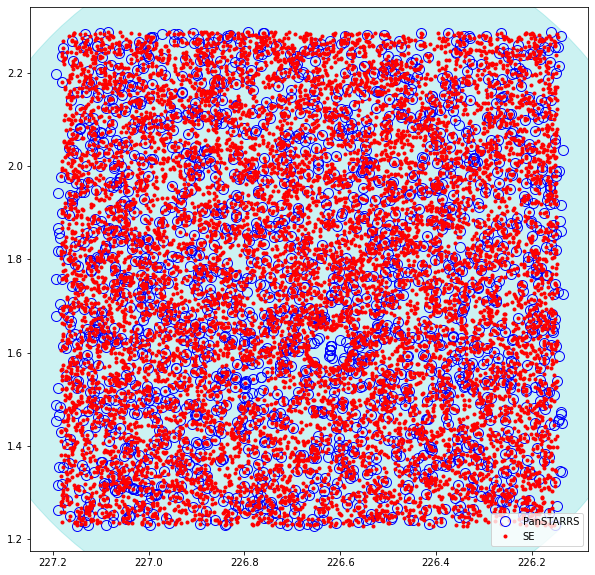

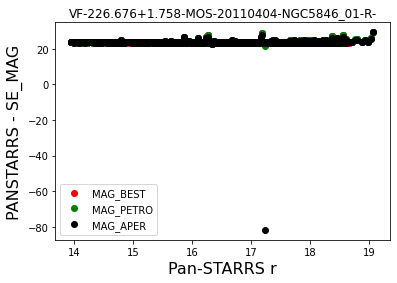

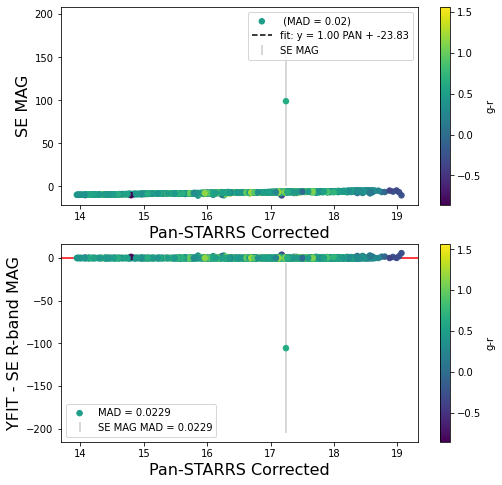

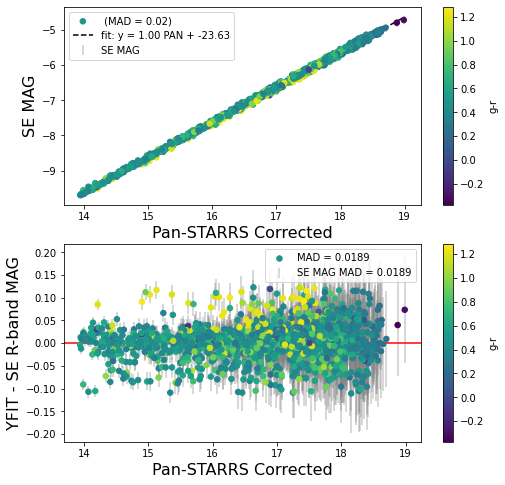

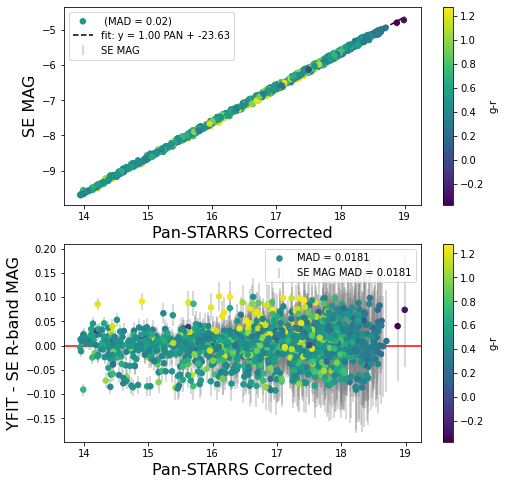

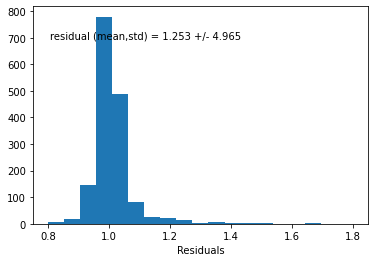

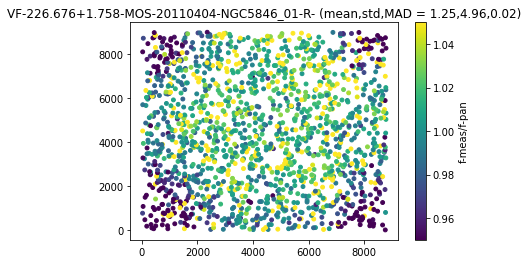

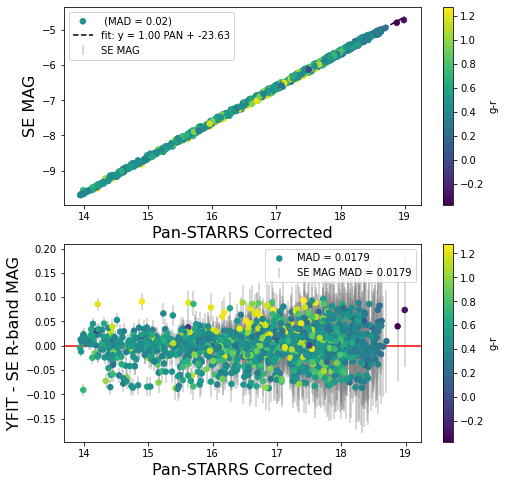

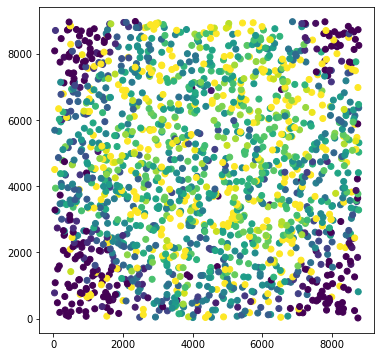

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(zp.residual_allx,zp.residual_ally,c=zp.residual_all,vmin=.96,vmax=1.04)

This looks like the sparsely sampled data, except mine is (x,y,z) versus an image.

In [14]:
# construct image
iheader = fits.getheader(zp.image)
(nx,ny) = iheader['NAXIS1'],iheader['NAXIS2']
new_img = np.tile(np.nan,(nx,ny) )
xindex = np.array((np.round(zp.residual_allx)),'i')
yindex = np.array((np.round(zp.residual_ally)),'i')
for i in range(len(xindex)):
    #print(xindex[i],yindex[i])
    #print(new_img[xindex[i],yindex[i]])
    new_img[xindex[i],yindex[i]] = zp.residual_all[i]
    #print(new_img[xindex[i],yindex[i]])

# My simple version

In [5]:
xdat,ydat,zdat = zp.residual_allx,zp.residual_ally,zp.residual_all

In [7]:
xr = np.arange(nx)
yr = np.arange(ny)
imout = np.zeros((nx,ny),'f')

In [53]:
boxsize=800

In [55]:
for i in range(boxsize//2,nx,boxsize):
    for j in range(boxsize//2,ny,boxsize):
        flag = np.sqrt((i-xdat)**2 + (j-ydat)**2) < boxsize
        if np.sum(flag) < 1:
            flag = np.sqrt((i-xdat)**2 + (j-ydat)**2) < 2*boxsize
        if np.sum(flag) < 1:
            flag = np.sqrt((i-xdat)**2 + (j-ydat)**2) < 3*boxsize
        #print(i-boxsize//2,i+boxsize//2,j-boxsize//2,j+boxsize//2)
        if i+boxsize//2 > nx:
            xmax = nx
        else:
            xmax = i+boxsize//2
        if j+boxsize//2 > nx:
            ymax = ny
        else:
            ymax = j+boxsize//2
        mean,median,std = sigma_clipped_stats(zdat[flag],sigma=2)
        imout[i-boxsize//2:xmax,j-boxsize//2:ymax] =\
        median*np.ones((xmax-(i-boxsize//2),ymax-(j-boxsize//2)))

Text(0.5, 1.0, 'data with smoothed fit')

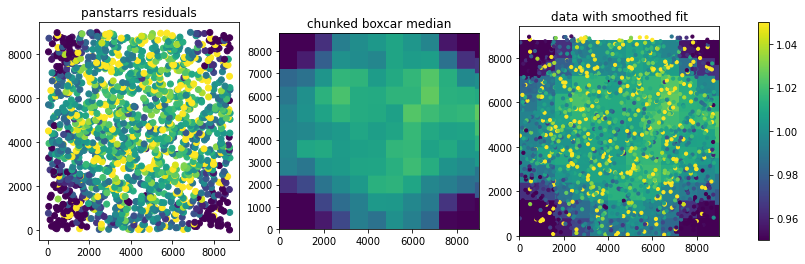

In [56]:
vmin=.95
vmax=1.05
plt.figure(figsize=(14,4))
allax = []
ax1 = plt.subplot(1,3,1)
plt.scatter(zp.residual_allx,zp.residual_ally,c=zp.residual_all,vmin=vmin,vmax=vmax)
plt.title('panstarrs residuals')
ax2 = plt.subplot(1,3,2)
plt.imshow(imout,vmin=vmin,vmax=vmax,origin="lower")
plt.title('chunked boxcar median')
ax3 = plt.subplot(1,3,3)
plt.imshow(imout,vmin=vmin,vmax=vmax,origin="lower")
plt.scatter(zp.residual_allx,zp.residual_ally,c=zp.residual_all,s=10,vmin=vmin,vmax=vmax)
plt.colorbar(ax=[ax1,ax2,ax3],fraction=.08)
plt.title('data with smoothed fit')
#plt.scatter(zp.residual_allx,zp.residual_ally,c=zp.residual_all,vmin=.96,vmax=1.04)

# Trying a 2D spline fit

https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html#d-smoothing-splines


### How do we use the output to normalize the image?

I need to create an image output from the spline fit so I can divide the input image by the flat correction.  But how do I create an image from this?

In [6]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [178]:
iheader = fits.getheader(zp.image)
(nx,ny) = iheader['NAXIS1'],iheader['NAXIS2']

flag = (zdat < 1.10) & (zdat > .85)
x,y,z = xdat[flag],ydat[flag],zdat[flag]

clip_flag = sigma_clip(zdat,sigma=3,maxiters=10,masked=True)
flag = ~clip_flag.mask
x,y,z = xdat[flag],ydat[flag],zdat[flag]

In [197]:
xnew_edges, ynew_edges = np.mgrid[0:nx:complex(nx+1), 0:ny:complex(ny+1)]
#xrange = np.arange(nx)
#yrange = np.arange(ny)
#xnew_edges, ynew_edges = np.meshgrid(xrange,yrange)
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] / 2.
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] / 2.
tck = interpolate.bisplrep(x, y, z, s=1000,kx=3,ky=3)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)
zim = np.transpose(znew)

Text(0.5, 1.0, 'Spline Interpolated function')

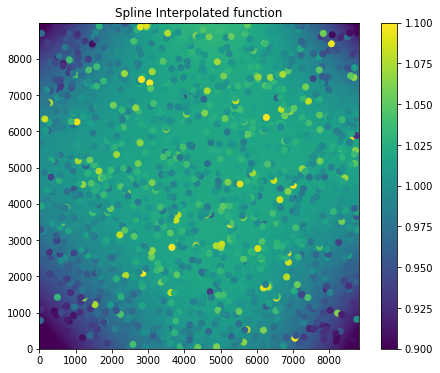

In [189]:
v1=.9
v2=1.1
plt.figure(figsize=(8,6))
plt.imshow(zim,vmin=v1,vmax=v2,origin="lower")
plt.scatter(x,y,c=z,vmin=v1,vmax=v2)
plt.colorbar()
plt.title("Spline Interpolated function")

In [199]:

print(zim.shape,ny,nx)

(9000, 8815) 9000 8815


# Testing spline fit for flattening

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


ZP = 23.629 +/- 0.000, fVF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits


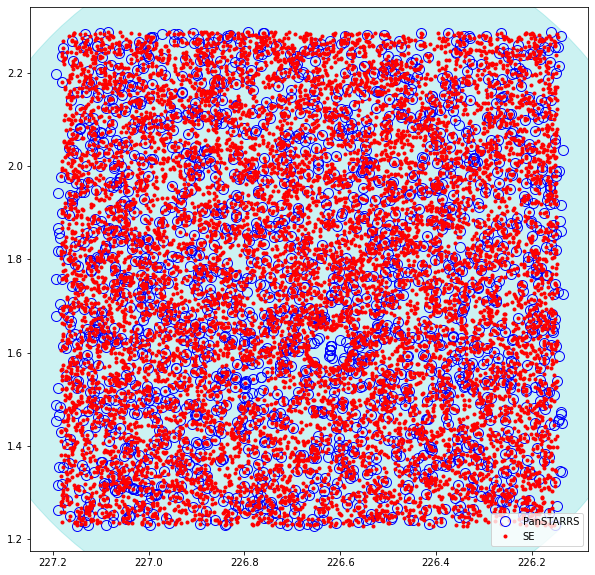

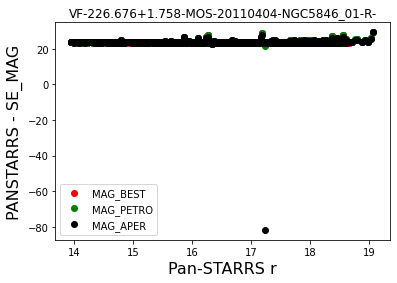

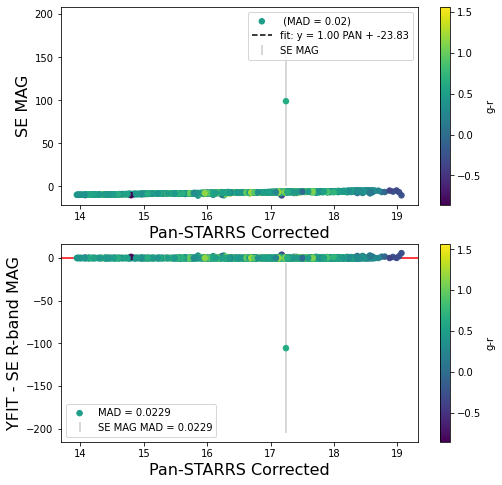

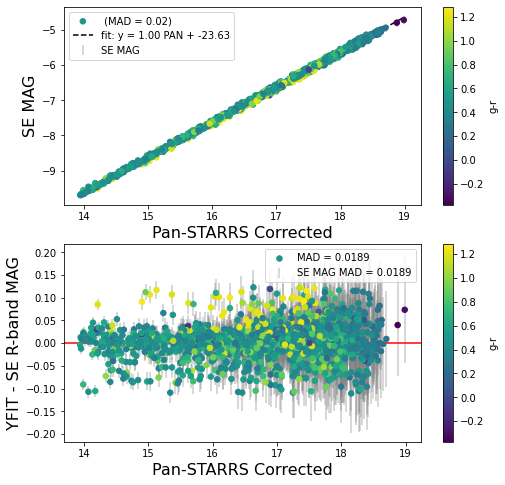

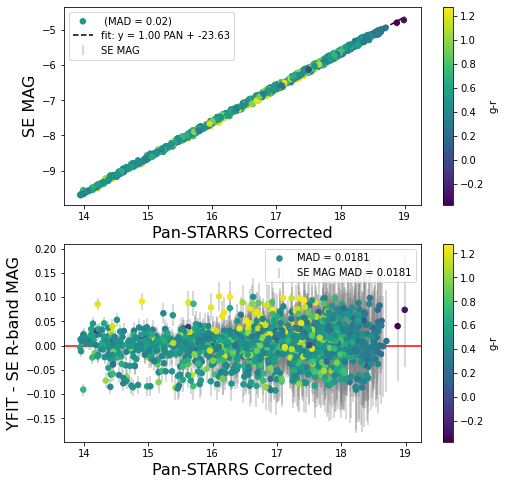

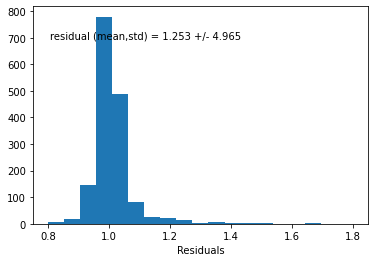

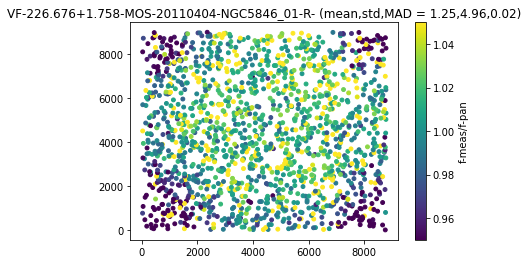

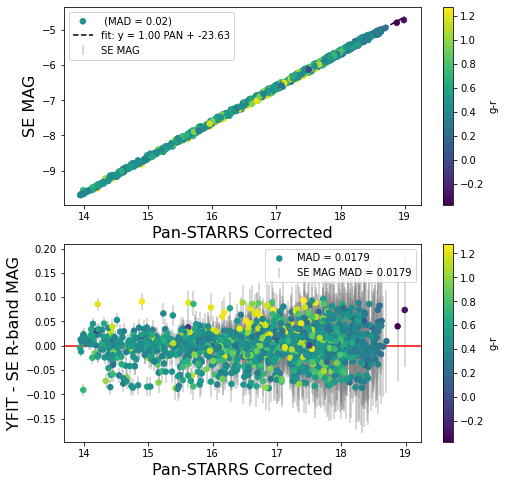

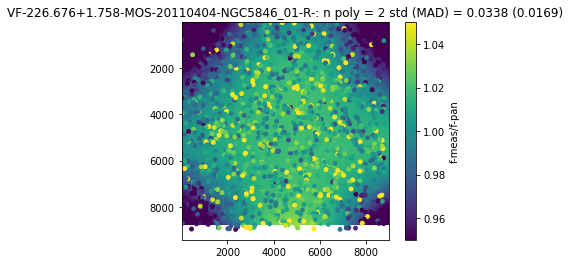

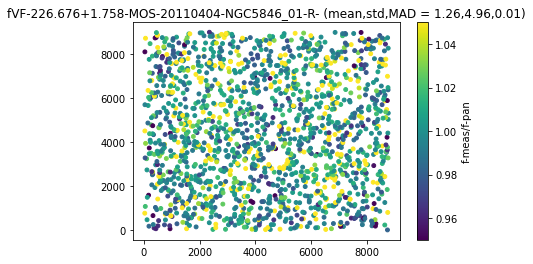

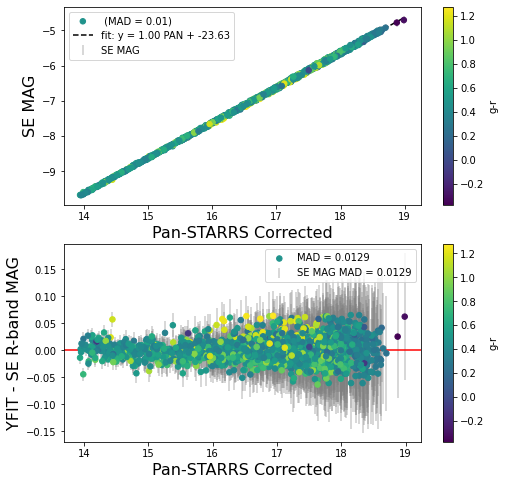

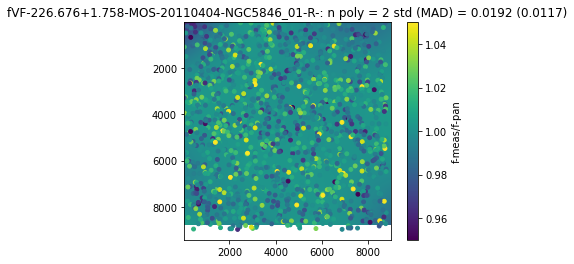

In [200]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits --instrument m --filter R --flatten 1

### Trying to get resulting image to match - maybe don't need to transpose?

removed transpose and running again

In [6]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits --instrument m --filter R --flatten 1 --spline

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



fitting 2d spline.  go refresh your coffee...

returning to your regular program...


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



fitting 2d spline.  go refresh your coffee...

returning to your regular program...
ZP = 23.629 +/- 0.000, fVF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits


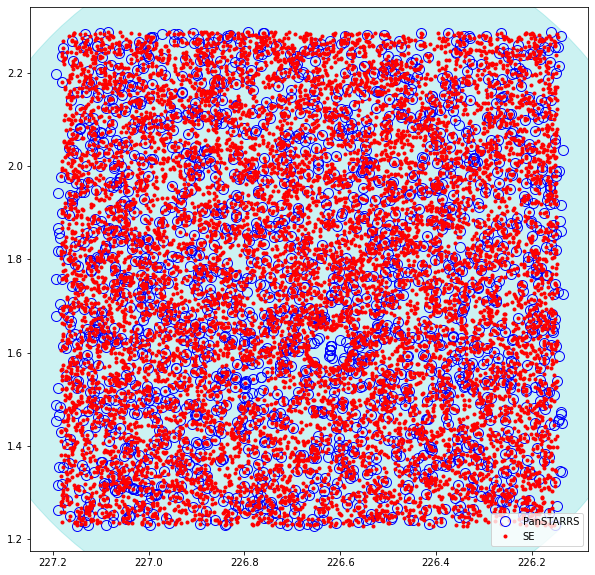

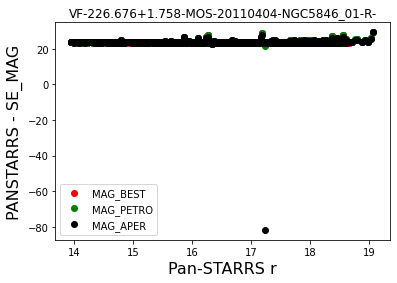

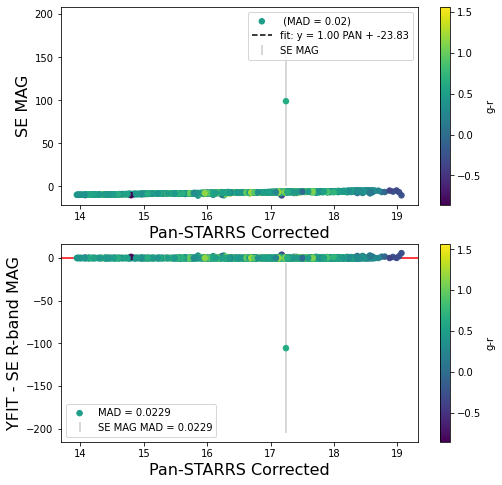

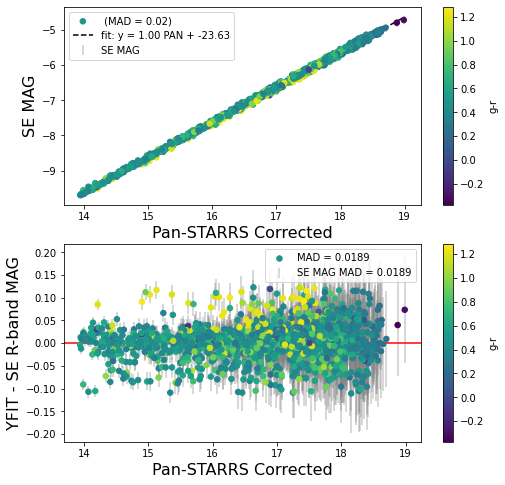

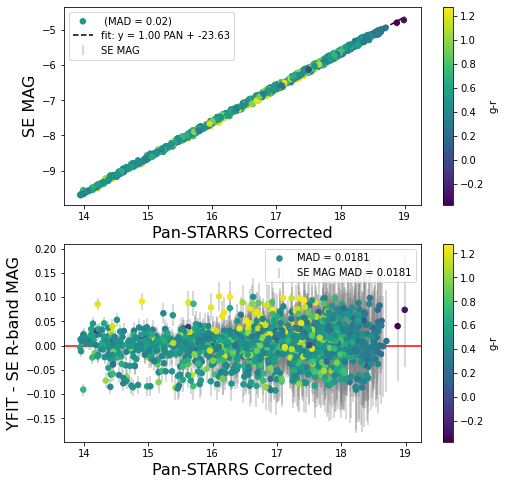

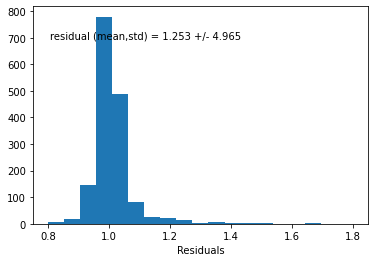

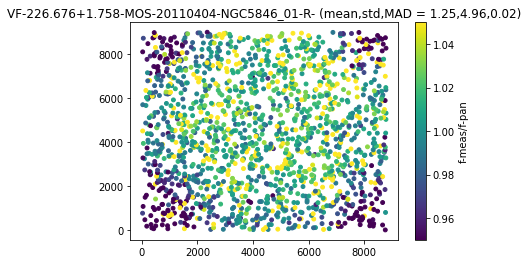

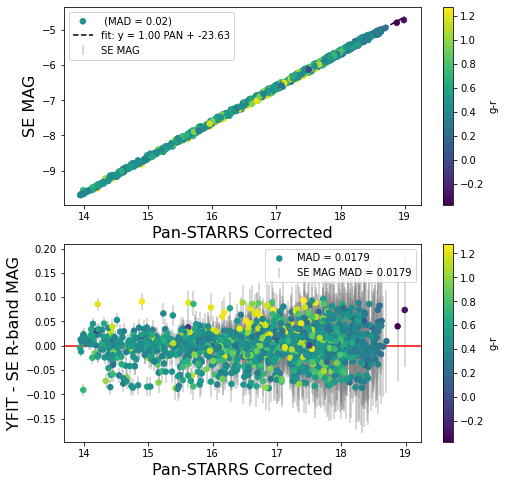

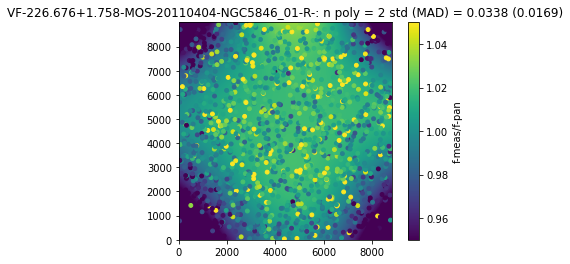

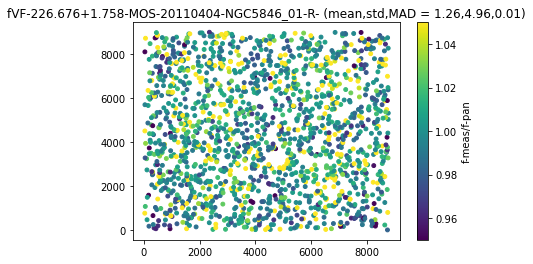

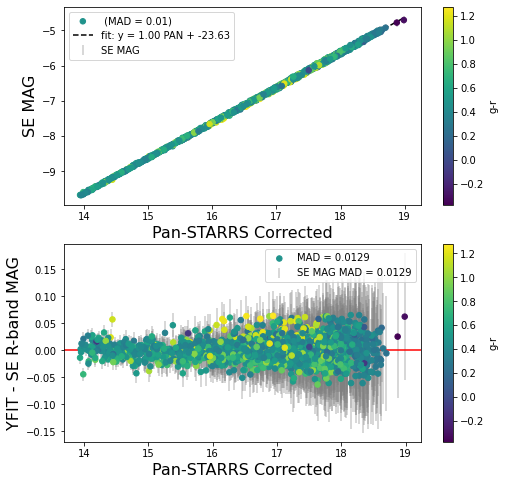

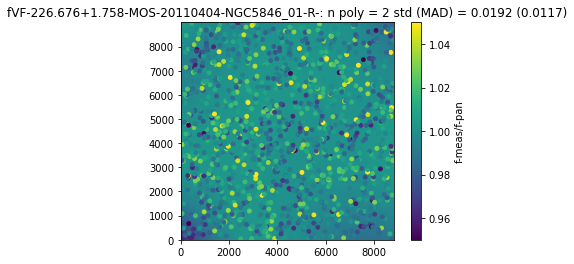

In [7]:
plt.show()

In [13]:
!ls VF*R.fits

VF-217.470+3.421-MOS-20120422-NGC5846_07-R.fits
VF-222.729+2.735-MOS-20120423-NGC5846_06-R.fits
VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits
VF-225.207+1.904-MOS-20110404-NGC5846_02-R.fits
VF-225.738+0.831-MOS-20120418-NGC5846_04-R.fits
VF-226.676+1.758-MOS-20110404-NGC5846_01-R.fits
VF-227.799+1.705-MOS-20110405-NGC5846_03-R.fits


In [ ]:
Rfiles = glob.glob('VF*R.fits')
for i in range(1,8):
    string = f"~/github/HalphaImaging/python3/getzp.py --image VF-226.676+1.758-MOS-20110404-NGC5846_0{i}-R.fits --instrument m --filter R --flatten 1 --spline"
    %run $string

In [11]:
for i in range(1,8):
    #string = f"!echo {i}"
    #%run $string
    print(i)

1
2
3
4
5
6
7


In [17]:
%run ~/github/HalphaImaging/python3/MOS_batch_getzp.py

python ~/github/HalphaImaging/python3/getzp.py --image VF-217.470+3.421-MOS-20120422-NGC5846_07-R.fits --instrument m --filter R --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-217.470+3.421-MOS-20120422-NGC5846_07-Ha4.fits --instrument m --filter ha --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-222.729+2.735-MOS-20120423-NGC5846_06-R.fits --instrument m --filter R --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-222.729+2.735-MOS-20120423-NGC5846_06-Ha4.fits --instrument m --filter ha --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits --instrument m --filter R --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-223.132+3.623-MOS-20130415-NGC5846_05-Ha4.fits --instrument m --filter ha --flatten 1 --spline
python ~/github/HalphaImaging/python3/getzp.py --image VF-225.207+1.904-MOS-20110404-NGC584

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


ZP = 23.121 +/- 0.003, VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits


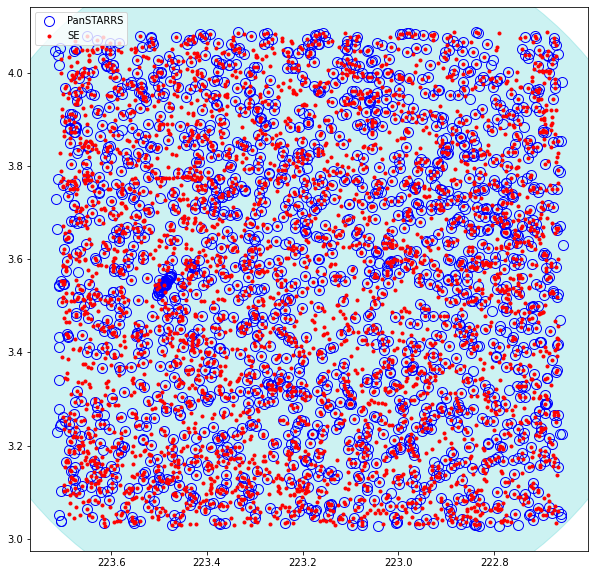

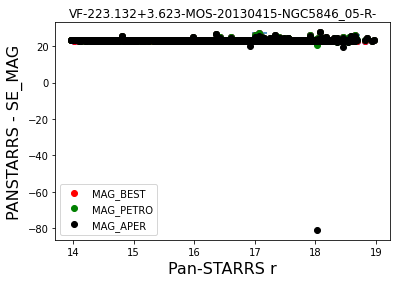

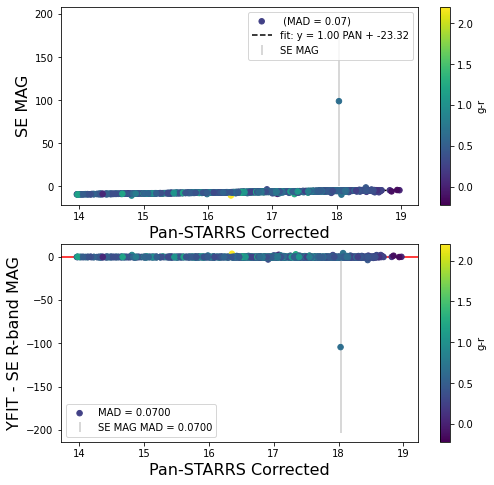

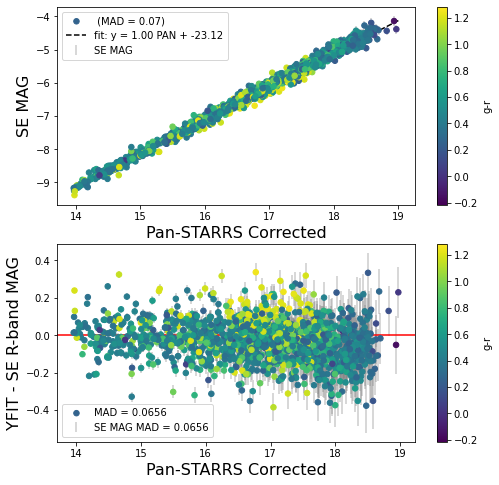

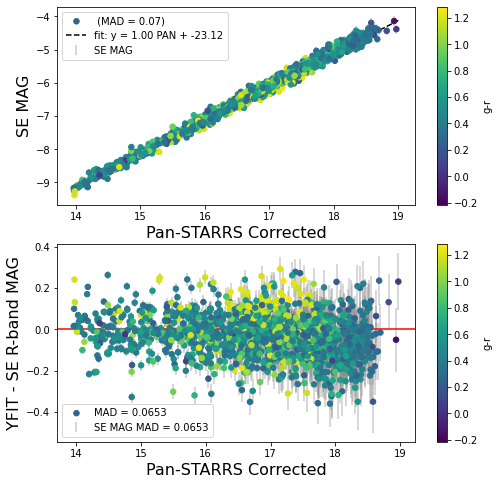

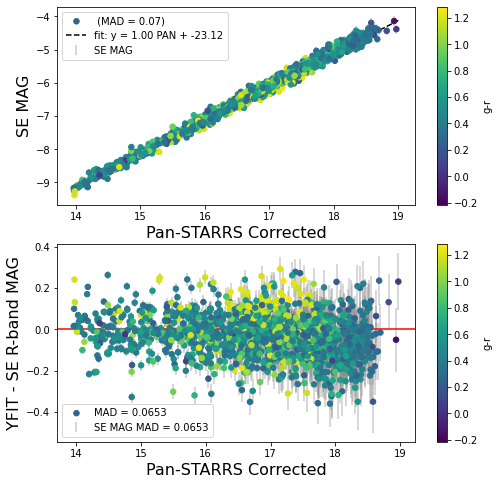

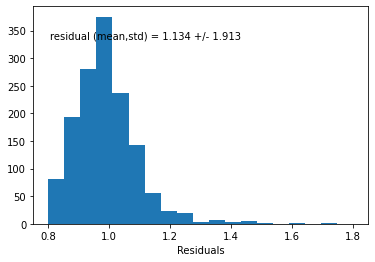

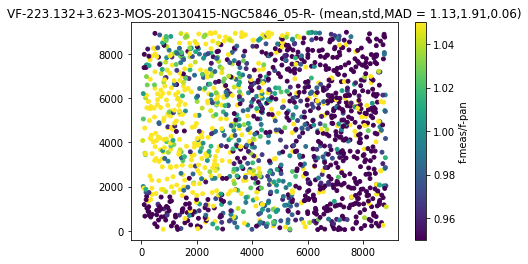

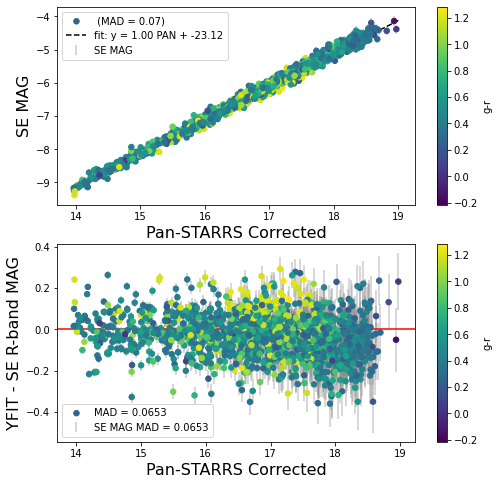

In [25]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits --instrument m --filter R 

In [36]:
xdat,ydat,zdat = zp.residual_allx,zp.residual_ally,zp.residual_all

In [37]:
iheader = fits.getheader(zp.image)
(nx,ny) = iheader['NAXIS1'],iheader['NAXIS2']

#flag = (zdat < 1.10) & (zdat > .85)
#x,y,z = xdat[flag],ydat[flag],zdat[flag]

clip_flag = sigma_clip(zdat,sigma=3,maxiters=10,masked=True)
flag = ~clip_flag.mask
x,y,z = xdat[flag],ydat[flag],zdat[flag]

In [62]:
xnew_edges, ynew_edges = np.mgrid[0:nx:complex(nx+1), 0:ny:complex(ny+1)]
#xrange = np.arange(nx)
#yrange = np.arange(ny)
#xnew_edges, ynew_edges = np.meshgrid(xrange,yrange)
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] / 2.
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] / 2.
tck = interpolate.bisplrep(x, y, z, s=300,kx=5,ky=5)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)
zim = np.transpose(znew)



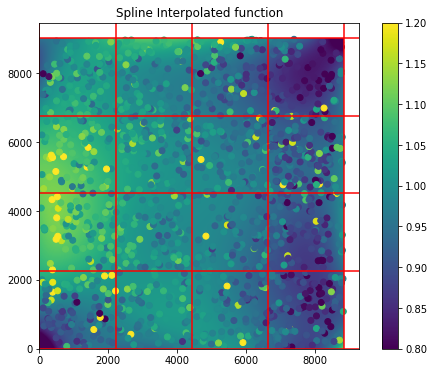

In [63]:
v1=.8
v2=1.2
plt.figure(figsize=(8,6))
plt.imshow(zim,vmin=v1,vmax=v2,origin="lower")
plt.scatter(x,y,c=z,vmin=v1,vmax=v2)
plt.colorbar()
plt.title("Spline Interpolated function")

ysections = [1600,6600]
ysections = [i*ny for i in np.arange(0,1.25,.25)]
for yl in ysections:
    plt.axhline(y=yl,c='r')
    

    
xsections = [1800,3200,6200]
xsections = [i*nx for i in np.arange(0,1.25,.25)]
for xl in xsections:
    plt.axvline(x=xl,c='r')

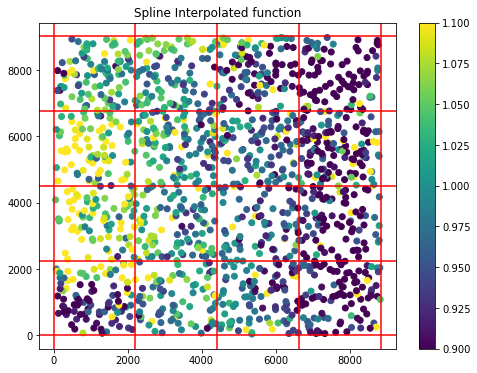

In [69]:
v1=.9
v2=1.1
plt.figure(figsize=(8,6))
#plt.imshow(zim,vmin=v1,vmax=v2,origin="lower")
plt.scatter(x,y,c=z,vmin=v1,vmax=v2)
plt.colorbar()
plt.title("Spline Interpolated function")

ysections = [1600,6600]
ysections = [i*ny for i in np.arange(0,1.25,.25)]
for yl in ysections:
    plt.axhline(y=yl,c='r')
    

    
xsections = [1800,3200,6200]
xsections = [i*nx for i in np.arange(0,1.25,.25)]
for xl in xsections:
    plt.axvline(x=xl,c='r')

found SE cat!!!
panstarrs table already downloaded
correcting color for R filter at KPNO


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



fitting 2d spline.  go refresh your coffee...

returning to your regular program...


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



fitting 2d spline.  go refresh your coffee...

returning to your regular program...
running a second round of flattening

fitting 2d spline.  go refresh your coffee...

returning to your regular program...


/Users/rfinn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



fitting 2d spline.  go refresh your coffee...

returning to your regular program...
ZP = 23.156 +/- 0.001, ffVF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits


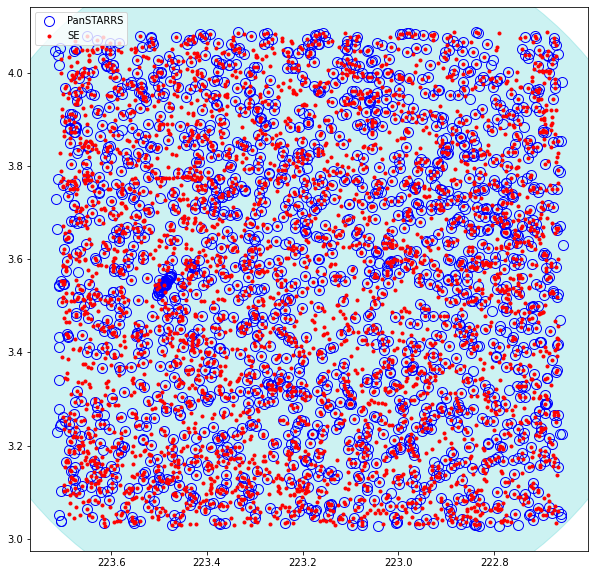

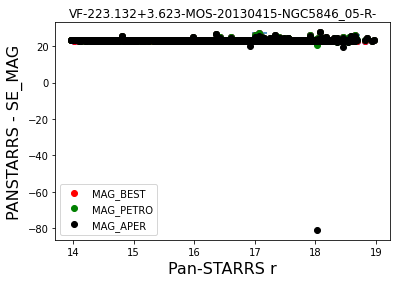

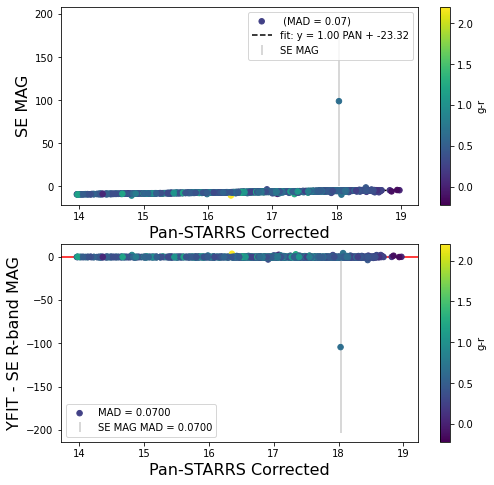

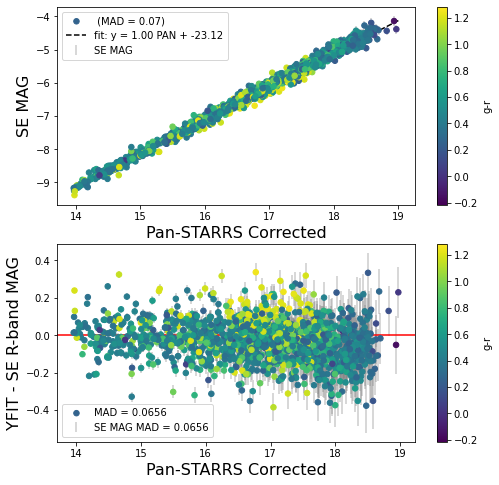

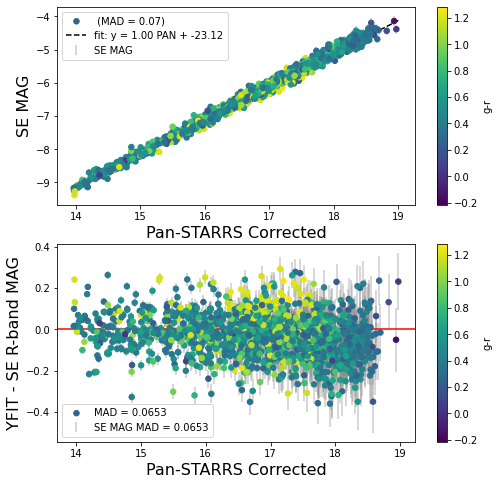

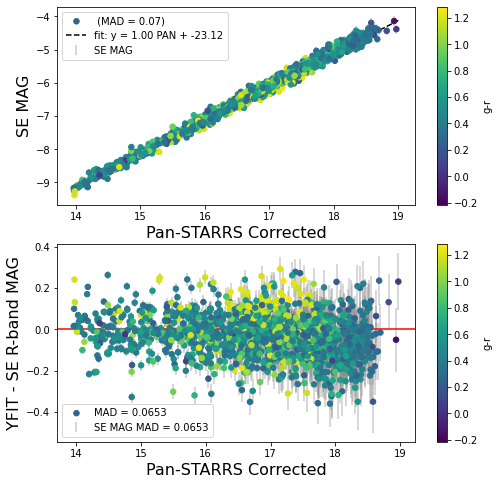

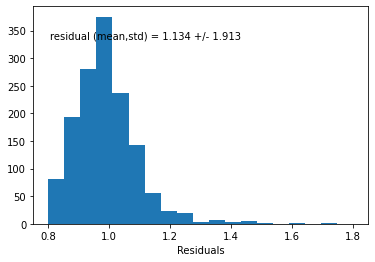

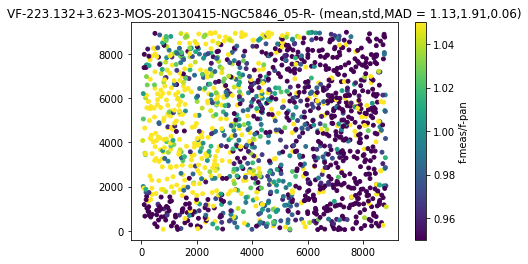

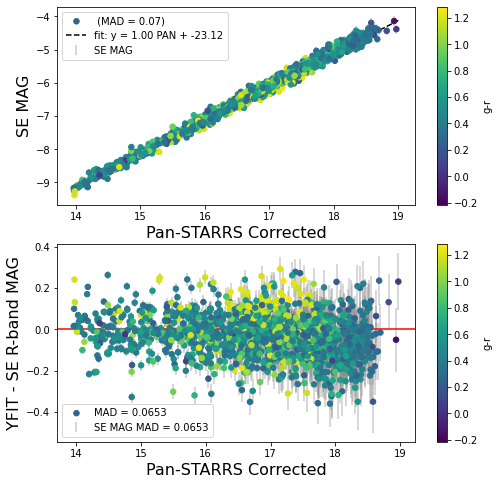

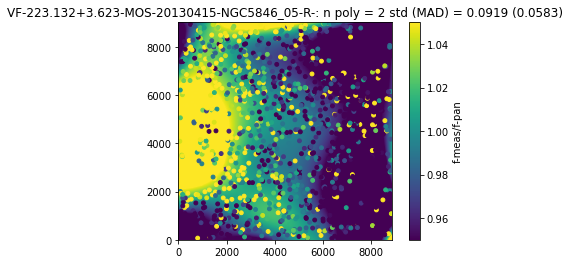

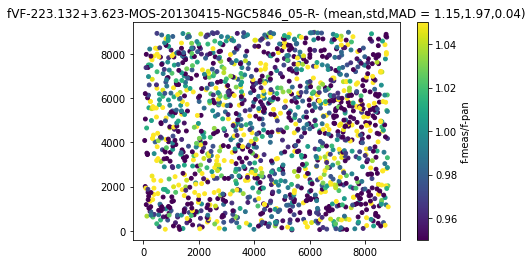

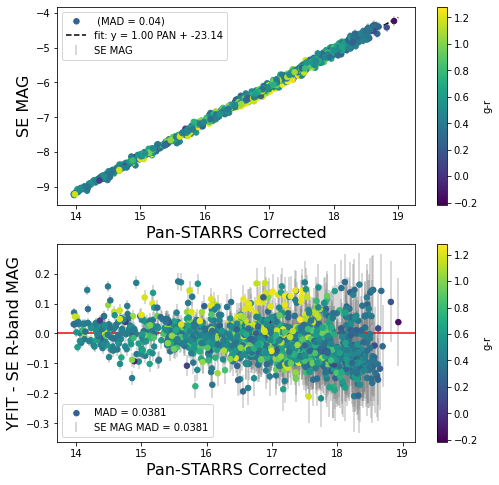

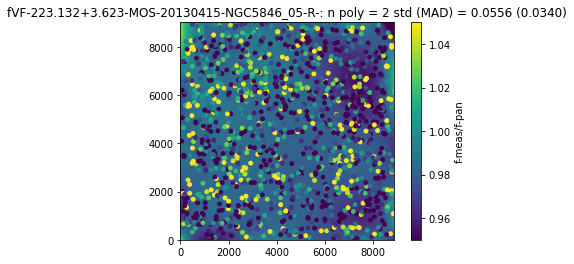

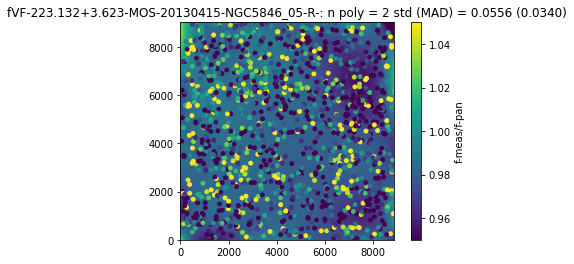

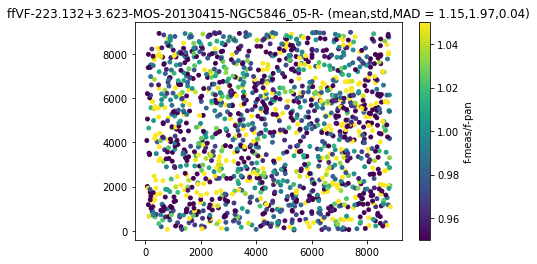

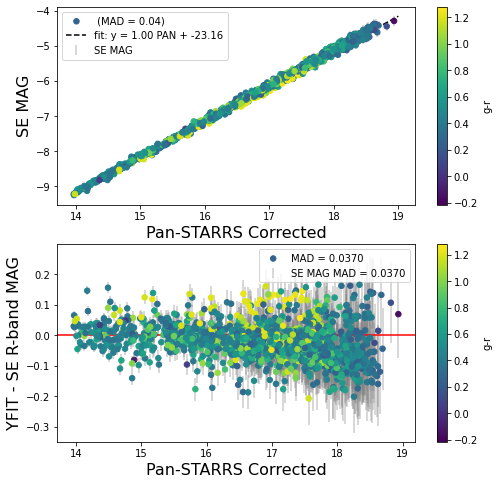

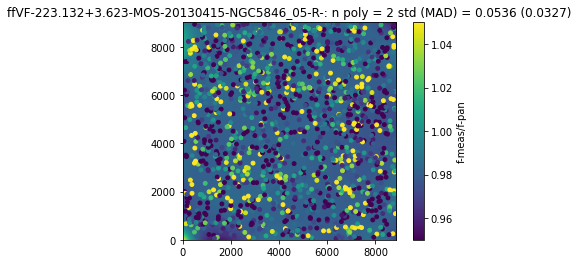

In [68]:
%run ~/github/HalphaImaging/python3/getzp.py --image VF-223.132+3.623-MOS-20130415-NGC5846_05-R.fits --instrument m --filter R --flatten 2 --spline --spline_order 5 --spline_smooth 300